# CRISP-DM

## This Notebook follows the standards of CRISP-DM as follows:

### 1) Business Understanding:
### What is Airbnb: it is a website that allows any individual to lease a property for a short duration, Airbnb business model is based on charging a commission on the leasers, the important qustion for leasers is how could I increse the reservations on my property ?


### 2) Data Understanding
### The data consists of three data sets (The data timeframe is one year): a listings data set which has all the information shown on the website about the property, a reviews data set that contains all the people's reviews regarding the property, and a calendar data set which when the property was available and when it was not


### 3) Data Preparation
### Cleaning and wrangling: The data was cleaned and prepared as seen in the Jupyter notebook attached in the respiratory: I have tried to find the positivity of a comment in a very basic way, I have gathered a list of positive and negative adjectives, then found the ratios of positive and negative adjectives to the length of the comment, then the data was aggregated as an average for each specific property, the new reviews dataset is attached in the respiratory


### 4) Modeling
### The data was modeled to find the best predictors for the response obtained from the calendar dataset which is "not_available_rate", it is assumed that if the property is not available on a certain day then it is leased, the higher the value the better, then the reviews data set and relevant columns in the listing dataset were used to predict the response.

### 5) Evaluation:
### After multiple iterations the final model explains 21% of the variation in the response variable, there might be more factors that contribute to the "not_available_rate" rather than the website itself.


### 6) Deployment:
### Some suggestions were made at the end of the notebook and in the Medium post.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from ast import literal_eval
from scipy import stats
%matplotlib inline

In [2]:
path = "C:\\Users\\faris\\Desktop\\Udacity Data Scientest\\Project 1\\Boston"

## Reading files

### Gathering Data

In [75]:
dict_dfs = {}
for file in os.listdir(path):
    dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)

In [76]:
dict_dfs.keys()

dict_keys(['calendar', 'listings', 'reviews'])

# Special treatment for the reviews dataframe to asses the postivity and negtivity of each comment, as the computation takes long time it will be save as the new csv file

### Cleaning

#Dropping rows with null comment
dict_dfs["reviews"] = dict_dfs["reviews"].dropna(subset=["comments"], axis = 0).reset_index(drop = True)

#https://gist.github.com/mkulakowski2/4289437
#The above link contains a text file for most used postive adjectives, which will be used to find the postivity of reviews
postive = pd.read_csv("Postive.csv")
postive = list(postive["ADJ"])

#https://gist.github.com/mkulakowski2/4289441
#The above link contains a text file for most used negtive adjectives, which will be used to find the negtivity of reviews
negtive = pd.read_csv("Negtive.csv")
negtive = list(negtive["ADJ"])

#lists which will have the the ratio of postive or negtive adjective to the total number of words in the comment
lst_postive_ratio = []
lst_negtive_ratio = []


#iterating over all comments in the dataframe
for comment in range(dict_dfs["reviews"].shape[0]):
    
    #getting all the words in the comment
    lst_of_comment_words = dict_dfs["reviews"]["comments"].iloc[comment].split(" ")
    #counter of postive or negtive words
    postive_count = 0
    negtive_count = 0
    
    for word in lst_of_comment_words:
        if word in postive:
            postive_count += 1
        elif word in negtive:
            negtive_count += 1
    #calculating the ratio of postive or negtive to the total number of words in the comment
    postive_ratio = postive_count/len(lst_of_comment_words)
    negtive_ratio = negtive_count/len(lst_of_comment_words)
    
    lst_postive_ratio.append(postive_ratio)
    lst_negtive_ratio.append(negtive_ratio)
    
    print(comment)
    
dict_dfs["reviews"]["postive_ratio"] = lst_postive_ratio
dict_dfs["reviews"]["negtive_ratio"] = lst_negtive_ratio

dict_dfs["reviews"].to_csv(path + "\\" + "reviews.csv")

# General Functions

### Gathering Data Function

In [3]:
def reading_dfs(path = "C:\\Users\\faris\\Desktop\\Udacity Data Scientest\\Project 1\\Boston"):
    '''
    A function which reads the CSVs in a path and return a dictinoray of all dataframes
    
    Input: a path of a folder which contains three files: listings.csv, calendar.csv, and the transformed reviews.csv
            which could be found in the CSV files.zip
            The files listings.csv, calendar.csv could be found in the data source
            
    Output: dictionary of the loaded dataframes
    
    '''
    dict_dfs = {}
    for file in os.listdir(path):
        dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)
        
    return dict_dfs

### Cleaning Data Function

In [4]:
def clean_calendar_df(df):
    '''
    A function to clean the calendar df
    
    Input: calendar dataframe
    
    Output: cleaned calendar dataframe
    
    '''
    #Transforming the calender data to the availability rate per id
    df = pd.DataFrame(df.groupby(["listing_id"])["available"].value_counts(normalize=True)).rename(columns = {"available":"count"}).reset_index()
    df = df.rename(columns = {"listing_id":"id"})

    #Filtering the data to get only the percentge when it is not available
    df = df[df["available"] == "f"].reset_index(drop = True)
    
    return df

### Cleaning Data Function

In [5]:
# A function to clean the listing df
def clean_listings_df(df,extra_columns = []): 
    '''
    A function to clean the listings df
    
    Input: listings dataframe, extra_columns which is a list of variables that will be added for trial 3
    
    Output: cleaned listings dataframe
    
    '''
    # Droping all rows which have the response value as null
    df = df.dropna(subset = ["not_available_rate"],axis = 0).reset_index(drop = True)

    # Changing house_rules column: Assign True if the propertey have house rules, False if it donse not have
    df["house_rules"] = df["house_rules"].apply(lambda x: "t" if "str" in str(type(x)) else "f")

    # Changing host_since column to be the diffrence between the most recent date in the column and the date, 
    # this will be much eaiser to interpret
    df["host_since"] = pd.to_datetime(df["host_since"]).apply(lambda x: (pd.to_datetime(df["host_since"]).max() - x).days)

    #Changing some columns to float
    df["host_response_rate"] = df["host_response_rate"].str[:-1].apply(float)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].str[:-1].apply(float)
    #These columns required removing a comma and $ to be converted to float
    for col in ['price', 'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee','extra_people']:
        df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


    #Getting the response value and the features matrix
    y = df["not_available_rate"]
    X = df[["house_rules","host_since","host_response_time","host_response_rate",
                              "host_acceptance_rate","host_is_superhost","host_listings_count","host_verifications",
                              "host_identity_verified",'neighbourhood_cleansed',
                              'is_location_exact', 'property_type', 'room_type', 'accommodates','bathrooms', 
                              'bedrooms', 'beds', 'bed_type','price', 'weekly_price', 'monthly_price', 
                              'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
                                'maximum_nights','number_of_reviews','instant_bookable','cancellation_policy', 
                              'require_guest_profile_picture','require_guest_phone_verification',"review_scores_rating"] + extra_columns].copy()

    return X,y

### Cleaning Data Function

In [6]:
def transfrom_catgorical(df):
    '''
     A function which transform catgorical data into dummy columns
     
     Input: listing dataframe
     
     Output: listing dataframe with the catagorical varibales are dummied
    
    
    '''
    cat_columns = list(df.select_dtypes(include = ["object"]).columns)
    for col in cat_columns:
        if col == "host_verifications": #This column treatment will be diffrent as it have list in each cell
            df = pd.concat([df.drop(col, axis = 1),pd.get_dummies(df[col].apply(lambda x: literal_eval(x)).explode(),prefix=col,prefix_sep="_").groupby(level=0).sum()],axis = 1).copy()
        else:
            df = pd.concat([df.drop(col, axis = 1),pd.get_dummies(df[col],prefix=col,prefix_sep="_")],axis = 1).copy()
    
    return df

### Modeling Data Function

In [7]:
def linear_reg(X,y):
    '''
    A function which takes X and y and generate a linear regresion model
    
    Input: X,y
    
    Output: linear regression model and the r_square value
    '''
    #Split data into training and test data, and fit a linear model
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
    lm_model = LinearRegression(normalize=True)

    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)# Predictions here
    r2_test = r2_score(y_test, y_test_preds) # Rsquared here


    return lm_model,r2_test

### A function to analyse and asses the produced model

In [8]:
def coef_weights_and_p(coefficients, X,y):
    '''
    This function is copied from the Udacity notebooks of this course
    A function which takes the model cofficients,X, and y to produce a table of coffiecents and P-values
    
    Input: model, X, and y
    
    Output: a dataframe which holds the cofficient and p-value of each feature in the input model 
    '''
    #https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/
    #Getting the p-values to asses the significance of each coffecent, the source of the code is the link above

    lm = LinearRegression()
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)
    new_X = np.append(np.ones((len(X),1)), X, axis=1)
    M_S_E = (sum((y-predictions)**2))/(len(new_X)-len(new_X[0]))
    v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
    s_b = np.sqrt(v_b)
    t_b = params/ s_b
    p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
    p_val = np.round(p_val,3)

    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df["p_val"] = list(p_val)[1:]
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    
    return coefs_df

## Question 1: What is the main contributers for a high reservations ?

# Trial 1

### It will be assumed that if the propertey is not avilable on a certin day then it is resrved, which means the lower the availability rate the better it is

## Reading Data 

In [9]:
dict_dfs = reading_dfs()

In [10]:
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

In [11]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

## Cleaning the data and choosing usable features

In [12]:
X,y = clean_listings_df(dict_dfs["listings"])

<ipython-input-5-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


## Transforming catgorical values to multiple columns

In [13]:
X = transfrom_catgorical(X)

## Imputing values into null cells for quantitative columns

In [14]:
#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating"]:
    X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating"]:
    X[col] = X[col].fillna(0)
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    X[col] = X[col].fillna(X[col].dropna().mean())

# Building a linear regresion model

In [15]:
model,r2 = linear_reg(X,y)

## Assesing the Model

In [16]:
r2

-1.2745495084205239e+25

In [17]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

<ipython-input-8-14bcb25ec7ef>:16: RuntimeWarning: invalid value encountered in sqrt
  s_b = np.sqrt(v_b)


In [18]:
#producing a list of significant coffecients which have a p-value less then 0.1 for trial 2
lst_of_sgnificant = list(coefs_df[coefs_df["p_val"] <= 0.1]["est_int"])

## Significant feauters are the ones with a p-value <= 0.1

# The large r squared value might be an indicator for an overfitted model, some of the features will be removed from the model based on the P-value

# Trial 2

## Reading Data 

In [19]:
### Reading Data dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

## Cleaning the data and choosing usable features

In [20]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [21]:
X,y = clean_listings_df(dict_dfs["listings"])

<ipython-input-5-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


## Transforming catgorical values to multiple columns

In [22]:
X = transfrom_catgorical(X)

## Imputing values into null cells for quantitative columns

In [23]:
## Imputing values into null cells for quantitative columns#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [24]:
#Getting only the feauters which were significant in the first model
X = X[lst_of_sgnificant].copy()

# Building a linear regresion model

In [25]:
model,r2 = linear_reg(X,y)

## Assesing the Model

In [26]:
r2

0.222346816437465

In [27]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [28]:
coefs_df

,est_int,coefs,abs_coefs,p_val
0,property_type_Camper/RV,-0.807426,0.807426,0.019
5,host_response_time_within an hour,-0.388198,0.388198,0.000
3,host_response_time_within a few hours,-0.368597,0.368597,0.000
8,host_verifications_manual_offline,0.299081,0.299081,0.000
6,host_response_time_within a day,-0.294904,0.294904,0.000
4,property_type_Other,-0.273304,0.273304,0.027
2,host_response_time_a few days or more,-0.270044,0.270044,0.013
1,property_type_Bed & Breakfast,-0.237974,0.237974,0.000
9,review_scores_rating_filled,-0.237688,0.237688,0.000
10,host_verifications_email,-0.161178,0.161178,0.002


# a much better r squared value was obtained

# Trial 3

## Adding the mean of postive and negtive ratios for the predector matrix X 

## Reading Data 

In [29]:
dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

## Cleaning the data and choosing usable features

In [30]:
#Group reviews dataframe by the listing_id and get the mean of postive and negtive ratios
dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()
dict_dfs["reviews"].rename(columns = {"listing_id": "id","postive_ratio":"mean_postive_ratio","negtive_ratio":"mean_negtive_ratio"}, inplace = True)

<ipython-input-30-8b657034e4fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()


In [31]:
#Adding an extra column to the lisiting dataset which have the response value: the mean of postive and negtive ratios of the comments 
dict_dfs["listings"]["mean_postive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_postive_ratio"])
dict_dfs["listings"]["mean_negtive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_negtive_ratio"])

In [32]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [33]:
X,y = clean_listings_df(dict_dfs["listings"], extra_columns=["mean_postive_ratio","mean_negtive_ratio"])

<ipython-input-5-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


## Transforming catgorical values to multiple columns

In [34]:
X = transfrom_catgorical(X)

## Imputing values into null cells for quantitative columns

In [35]:
## Imputing values into null cells for quantitative columns#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating","mean_postive_ratio","mean_negtive_ratio"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating","mean_postive_ratio","mean_negtive_ratio"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [36]:
#Getting only the feauters which were significant in the first model
lst_of_sgnificant = lst_of_sgnificant + ["mean_postive_ratio","mean_negtive_ratio"]
X = X[lst_of_sgnificant].copy()

# Building a linear regresion model

In [37]:
model,r2 = linear_reg(X,y)

## Assesing the Model

In [38]:
r2

0.21337712576332024

In [39]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [40]:
coefs_df

,est_int,coefs,abs_coefs,p_val
23,mean_negtive_ratio,-1.374090,1.374090,0.439
22,mean_postive_ratio,0.874244,0.874244,0.056
0,property_type_Camper/RV,-0.806971,0.806971,0.019
5,host_response_time_within an hour,-0.387378,0.387378,0.000
3,host_response_time_within a few hours,-0.365598,0.365598,0.000
8,host_verifications_manual_offline,0.298955,0.298955,0.000
6,host_response_time_within a day,-0.293917,0.293917,0.000
2,host_response_time_a few days or more,-0.281770,0.281770,0.011
4,property_type_Other,-0.248645,0.248645,0.035
1,property_type_Bed & Breakfast,-0.234807,0.234807,0.000


# Trial 4

## What happens if merged mean_postive_ratio and mean_negtive_ratio into one column

## Reading Data 

In [41]:
## Reading Data dict_dfs = reading_dfs()
dict_dfs["calendar"] = clean_calendar_df(dict_dfs["calendar"])

## Cleaning the data and choosing usable features

In [42]:
## Cleaning the data and choosing usable features#Group reviews dataframe by the listing_id and get the mean of postive and negtive ratios
dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()
dict_dfs["reviews"].rename(columns = {"listing_id": "id","postive_ratio":"mean_postive_ratio","negtive_ratio":"mean_negtive_ratio"}, inplace = True)

<ipython-input-42-8b657034e4fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dict_dfs["reviews"] = dict_dfs["reviews"].groupby(["listing_id"], as_index = False)["postive_ratio","negtive_ratio"].mean()


In [43]:
#Adding an extra column to the lisiting dataset which have the response value: the mean of postive and negtive ratios of the comments 
dict_dfs["listings"]["mean_postive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_postive_ratio"])
dict_dfs["listings"]["mean_negtive_ratio"] = dict_dfs["listings"]["id"].map(dict_dfs["reviews"].set_index("id")["mean_negtive_ratio"])
dict_dfs["listings"]["comments_postivity"] = dict_dfs["listings"]["mean_postive_ratio"] - dict_dfs["listings"]["mean_negtive_ratio"] 

In [44]:
#Adding an extra column to the lisiting dataset which have the response value: the not available rate (the higher the better)
dict_dfs["listings"]["not_available_rate"] = dict_dfs["listings"]["id"].map(dict_dfs["calendar"].set_index("id")["count"])

In [45]:
X,y = clean_listings_df(dict_dfs["listings"], extra_columns=["comments_postivity"])

<ipython-input-5-331ad2e373f8>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$","").str.replace(",","").apply(float)


## Transforming catgorical values to multiple columns

In [46]:
X = transfrom_catgorical(X)

## Imputing values into null cells for quantitative columns

In [47]:
## Imputing values into null cells for quantitative columns#adding an extra column to indicate if the cell is null or filled for special weekly and monthly prices and review_scores_rating
for col in ["weekly_price","monthly_price","review_scores_rating","comments_postivity"]:
    try:
        X[col + "_filled"] = X[col].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    except:
        pass
#any null value in these columns will be filled with ZERO
for col in ["bathrooms","bedrooms","beds","security_deposit","cleaning_fee","weekly_price","monthly_price","review_scores_rating","comments_postivity"]:
    try:
        X[col] = X[col].fillna(0)
    except:
        pass
#any value in these columns will be filled with the average of the column
for col in ["host_response_rate","host_acceptance_rate"]:
    try:
        X[col] = X[col].fillna(X[col].dropna().mean())
    except:
        pass

In [48]:
lst_of_sgnificant = ['property_type_Camper/RV',
 'property_type_Bed & Breakfast',
 'host_response_time_a few days or more',
 'host_response_time_within a few hours',
 'property_type_Other',
 'host_response_time_within an hour',
 'host_response_time_within a day',
 'host_verifications_weibo',
 'host_verifications_manual_offline',
 'review_scores_rating_filled',
 'host_verifications_email',
 'monthly_price_filled',
 'host_verifications_facebook',
 'bedrooms',
 'review_scores_rating',
 'number_of_reviews',
 'host_response_rate',
 'cleaning_fee',
 'host_acceptance_rate',
 'price',
 'host_listings_count',
 'host_since']

In [49]:
#Getting only the feauters which were significant in the first model
lst_of_sgnificant = lst_of_sgnificant + ["comments_postivity","comments_postivity_filled"]
X = X[lst_of_sgnificant].copy()

# Building a linear regresion model

In [50]:
model,r2 = linear_reg(X,y)

## Assesing the Model

In [51]:
r2

0.21309317938891292

In [52]:
coefs_df = coef_weights_and_p(model.coef_,X,y)

In [53]:
coefs_df

,est_int,coefs,abs_coefs,p_val
22,comments_postivity,1.015225,1.015225,0.018
0,property_type_Camper/RV,-0.806395,0.806395,0.019
5,host_response_time_within an hour,-0.386524,0.386524,0.000
3,host_response_time_within a few hours,-0.364173,0.364173,0.000
8,host_verifications_manual_offline,0.299795,0.299795,0.000
6,host_response_time_within a day,-0.293517,0.293517,0.000
2,host_response_time_a few days or more,-0.283806,0.283806,0.011
4,property_type_Other,-0.251033,0.251033,0.033
1,property_type_Bed & Breakfast,-0.233642,0.233642,0.000
10,host_verifications_email,-0.163987,0.163987,0.002


# Qustions and answers from the data

## Q1: What are the availabilty rates for Airbnbs in Boston

In [73]:
#Readiing dataframes
dict_dfs = {}
for file in os.listdir(path):
    dict_dfs[file[:-4]] = pd.read_csv(path + "\\" + file)

In [74]:
#transfrom the data to be aggregated based on month and year
dict_dfs["calendar"]["year_month"] = pd.to_datetime(dict_dfs["calendar"]["date"]).dt.strftime('%Y-%m')
dict_dfs["calendar"] = pd.DataFrame(dict_dfs["calendar"].groupby(["year_month"]).available.value_counts(normalize=True)).rename(columns = {"available":"available_rate"}).reset_index()

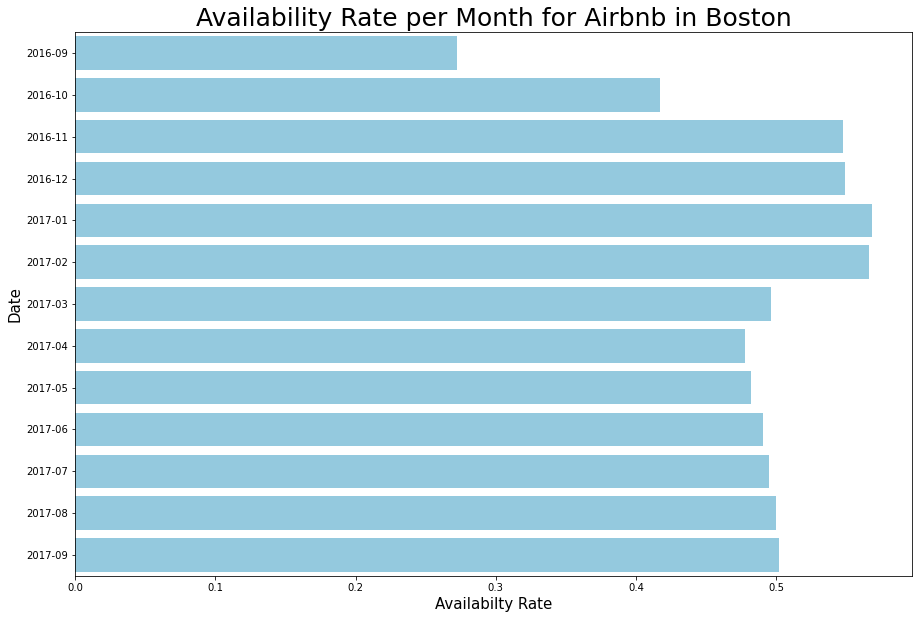

In [75]:
plt.figure(figsize=[15,10])
sns.barplot(y = dict_dfs["calendar"][dict_dfs["calendar"]["available"] == "t"]["year_month"], x = dict_dfs["calendar"][dict_dfs["calendar"]["available"] == "t"]["available_rate"],color="skyblue")
plt.title("Availability Rate per Month for Airbnb in Boston", fontsize = 25)
plt.xlabel("Availabilty Rate", fontsize = 15)
plt.ylabel("Date", fontsize = 15)
plt.savefig("Availability Rate.jpeg");

## Q2: What are the features on listings which leads to higher reservations

### The answer here will depend on the results from the forth trial

In [76]:
#extracting feauters with postive coefficents
postive_coefs = coefs_df[coefs_df["coefs"] > 0].copy()

In [77]:
#normalizing the coffecients
postive_coefs["norm_coefs"] = (postive_coefs["coefs"]/postive_coefs["coefs"].sum())*100

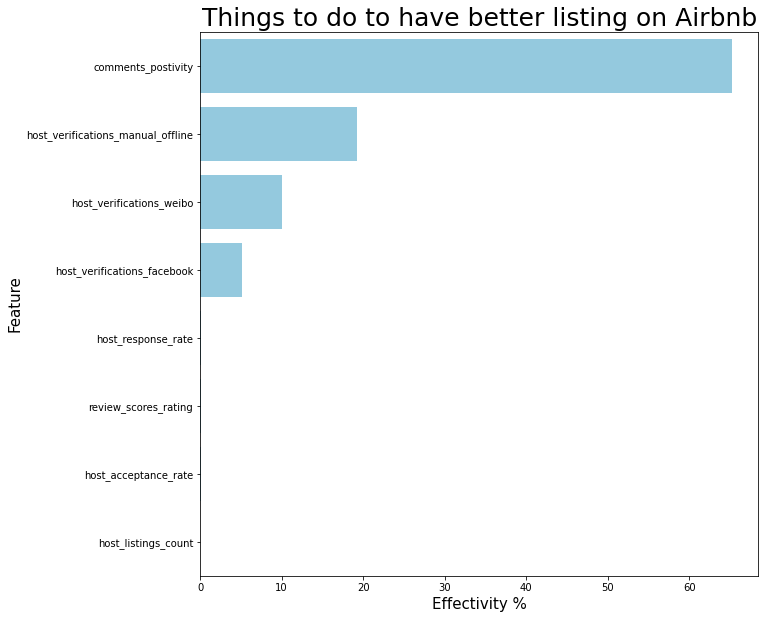

In [80]:
plt.figure(figsize=[10,10])
sns.barplot(x = postive_coefs["norm_coefs"], y = postive_coefs["est_int"],color="skyblue")
plt.title("Things to do to have better listing on Airbnb", fontsize = 25)
plt.xlabel("Effectivity %", fontsize = 15)
plt.ylabel("Feature", fontsize = 15)
plt.savefig("Things to do.jpeg",bbox_inches = 'tight');

## Q3: What are the features on listings which leads to lower reservations

### The answer here will depend on the results from the forth trial

In [60]:
#extracting feauters with negtive coefficents
negtive_coefs = coefs_df[coefs_df["coefs"] < 0].copy()

In [61]:
#normalizing the coffecients
negtive_coefs["norm_coefs"] = (negtive_coefs["coefs"]/negtive_coefs["coefs"].sum())*100

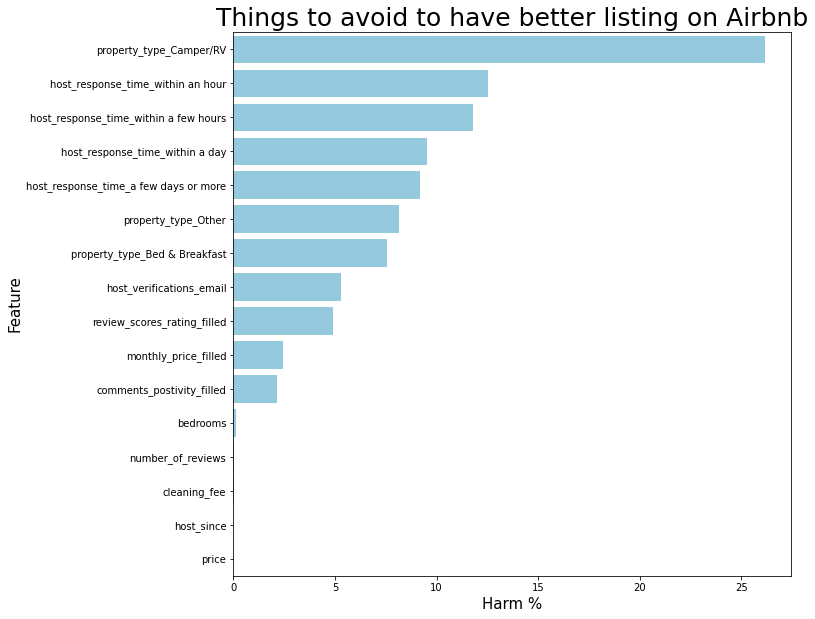

In [81]:
plt.figure(figsize=[10,10])
sns.barplot(x = negtive_coefs["norm_coefs"], y = negtive_coefs["est_int"],color="skyblue")
plt.title("Things to avoid to have better listing on Airbnb", fontsize = 25)
plt.xlabel("Harm %", fontsize = 15)
plt.ylabel("Feature", fontsize = 15)
plt.savefig("Things to avoid.jpeg",bbox_inches = 'tight');